# Introduction 

Quantum computations are expressed by quantum circuits, which consist of a list of gates, $G_1G_2...G_k$, each being a unitary matrix (a matrix $U$ is called unitary if $U^{-1}\,{=}\,U^\dagger$).  The basic gates include the identity transformation($Id$) that performs no computation, and Pauli matrices : <br>
<h3>
$$Id = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\hspace{1cm}X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}\hspace{1cm}Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}\hspace{1cm}Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$$
</h3>
<br>
All single-qubit quantum computations $U_1$ can be obtained by multiplyingthe roots of Pauli matrices (also known as Euler’s angle decomposition. However, to implement quantum transformations spanning multiple qubits, we need gates spanning more than one qubit, otherwise known as entangling gates.  It turns out that it suffices to add a very simple gate, called the $\text{CNOT}$ and defined as follows,
<h3>
$$ \text{CNOT} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix},$$
</h3>
to obtain computational universality in the sense of the ability to express arbitrary transformations as circuits with $U$ and $\text{CNOT}$ gates.  Both leading quantum computing technologies, superconducting circuits and trapped ions, allow a straightforward physical-level implementation of the above gates in practice. In both technologies, the cost of implementing the $\text{CNOT}$ gate exceeds that of arbitrary single-qubit $U_1$ gates.  Thus, an efficient quantum computation minimizes the use of the $\text{CNOT}$ gates

For instance, the Toffoli gate, performing the transformation $|a,b,c\rangle\mapsto|a,b,c\oplus ab\rangle$, is a quantum version of the Boolean AND gate; it can be implemented as shown in Figure 1.
![2560px-Qcircuit_ToffolifromCNOT.svg.png](2560px-Qcircuit_ToffolifromCNOT.svg.png "ShowMyImage")
Figure 1: Implementation of the Toffoli gate using two Hadamard gates $\text{H}$, six $\text{CNOT}$ gates, and seven $\text{T/}\hspace{0.1cm}\text{T}^\dagger$gates (credit: Wikipedia).  Individual qubits are denoted by horizontal wires, time flows from left to right.

A quantum circuit is said to implement an $n$-input $m$-output Boolean function $f(x)$ if it computes the transformation $|x,0,0\rangle \mapsto e^{i\theta(x)}|x,f(x),0\rangle$ for some arbitrary real-valued function $\theta(x)$, i.e., first part of the register passes unchanged, the second part accumulates the bit values of the desired function $f(x)$, and the third part, with $S$ qubits, is used as a computational scratch space. When $\theta(x) \equiv 2\pi$, implying $e^{i\theta(x)} \equiv 1$, the implementation is called phaseless.  We consider the phase $\theta(x)$ irrelevant in what follows, which is consistent with measuring the $m$ output bits immediately after implementing the circuit. Allowing the phase to take different values depending on the input introduces a degree of freedom that can be explored to obtain shorter circuits, as there are fewer conditions for the circuit to satisfy.  The total number of qubits spanned by such a circuit is $n\,{+}\,m\,{+}\,S$.  Note that the $S$-qubit scratch space needs to be returned to value $|0\rangle$ as otherwise, the implementation may not be used in quantum algorithms due to unwanted entanglement residing on the unreset scratch qubits.


# 1. Compute popcount function for n = 4 qubits
Popcount, also known as the Hamming weight or simply weight, is a popular instruction in classical computing that is utilized in certain implementations of quantum algorithms. In particular, this includes Hamiltonian dynamics simulation algorithms, which are considered to be among the most important as they offer exponential advantage over best-known classical algorithms for solutions to practical problems (in areas such as many-body physics, materials research, and chemistry). For the Boolean $n$-tuple $(x_1,x_2,...,x_n)$, popcount is defined as the integer sum of inputs, 
<h3>
$$\text{Popcount}(x_1,x_2,...,x_n)=(y_1,y_2,...,y_m)=x_1+x_2+...+x_n, $$
</h3>
where $m=\lfloor\log(n)\rfloor+1.$

The task here is two provide three QASM circuits computing the mappings $|x,0,0\rangle \mapsto e^{i\theta_j(x)}|x,y_j(x),0\rangle$ expressed using single-qubit and $\text{CNOT}$ gates, where $(y_1,y_2,y_3) \,{=}\, \text{Popcount}(x)$ is the 4-input 3-output Popcount function and $j \in \{1,2,3\}$. Each of the three will be scored separately.

In [42]:
from qiskit import *
import numpy as np
def C2X(circ, control_qubit1, control_qubit2, target_qubit):    
    
    circ.ch(control_qubit1, target_qubit)
    circ.cz(control_qubit2, target_qubit)
    circ.ch(control_qubit1, target_qubit)
    
    return circ

def CS():
    circ = QuantumCircuit(1)
    circ.s(0)
    circ = circ.control(1)
    
    return circ

def CS_dagger():
    circ = QuantumCircuit(1)
    circ.sdg(0)
    circ = circ.control(1)
    
    return circ

def CCZ(n, c1, c2, t):
    circ = QuantumCircuit(n)
    circ = circ.compose(CS(), [c2, t])
    circ.cx(c1, c2)
    circ = circ.compose(CS_dagger(), [c2, t])
    circ.cx(c1, c2)
    circ = circ.compose(CS(), [c1, t])

    return circ

def C3X(n, c1, c2, c3, t):

    circ = QuantumCircuit(n)
    circ.ch(c1, t)
    circ += CCZ(n, c2, c3, t)
    circ.ch(c1, t)
    return circ

def C4X(circ, c1, c2, c3, c4, t):

    circ.ch(c1, t)
    circ.h(t)
    circ.mct([c2, c3, c4], t)
    circ.h(t)
    circ.ch(c1, t)
    return circ

## a) Circuit for j = 1
<h3>
$$|x,0,0\rangle \mapsto e^{i\theta_{1}(x)}|x,y_{1}(x),0\rangle$$

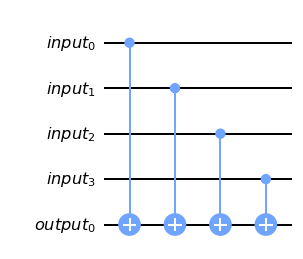

In [33]:
# Importing the qiskit module
from qiskit import *

# Defining input, output and scratch qubits
x =   4  # number of input qubits
y1 =   1 # number of output qubit 
s1 =  0 # number of scratch qubit

# Defining Quantum Circuit with the given circuits
def Circuit_1(In,Ou,Sc):
    if Sc != 0:
        # initiating required qubits
        X = QuantumRegister(In, 'input') 
        Y = QuantumRegister(Ou, 'output') 
        S = QuantumRegister(Sc, 'scratch')  
        # creating circuit with above qubits
        Circ = QuantumCircuit(X,Y,S)
    else:
        
        # initiating required qubits
        X = QuantumRegister(In, 'input') 
        Y= QuantumRegister(Ou, 'output') 
        
        # creating circuit with above qubits
        Circ = QuantumCircuit(X,Y)
    
    ##### Create you circuit below #########
    Circ.cx(0,4)
    Circ.cx(1,4)
    Circ.cx(2,4)
    Circ.cx(3,4)
    ########################################
    
    # Uncomment to draw quantum circuit
    display(Circ.draw('mpl'))
    
    # Transpiling the circuit into u, cnot
    Circ = transpile(Circ, basis_gates=['u3','cx'])
    
    # Uncomment to draw transpiled circuit
#     display(Circ.draw('mpl'))
    
    return Circ

qc_1a = Circuit_1(x,y1,s1)

### Grader

In [34]:
from qc_grader import grade_ex1a

grade_ex1a(qc_1a)

Grading your answer for ex1/partA. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 8.
Feel free to submit your answer.



## b) Circuit for j = 2
<h3>
 $$|x,0,0\rangle \mapsto e^{i\theta_{2}(x)}|x,y_{2}(x),0\rangle$$

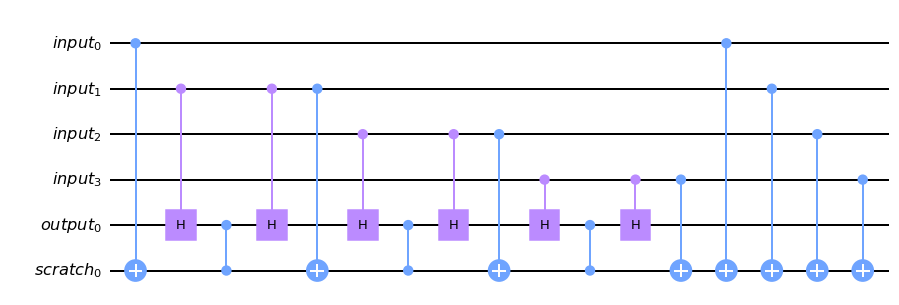

In [35]:
# Importing the qiskit module
from qiskit import *

# Defining input, output and scratch qubits
x =    4 # number of input qubits
y2 =   1 # number of output qubit 
s2 =   1 # number of scratch qubit

# Defining Quantum Circuit with the given circuits
def Circuit_2(In,Ou,Sc):
    if Sc != 0:
        # initiating required qubits
        X = QuantumRegister(In, 'input') 
        Y = QuantumRegister(Ou, 'output') 
        S = QuantumRegister(Sc, 'scratch')  
        
        # creating circuit with above qubits
        Circ = QuantumCircuit(X,Y,S)
    else:
        
        # initiating required qubits
        X = QuantumRegister(In, 'input') 
        Y= QuantumRegister(Ou, 'output') 
        
        # creating circuit with above qubits
        Circ = QuantumCircuit(X,Y)
    
    ##### Create you circuit below #########
    Circ.cx(0, 5)
#     Circ.ccx(1, 5, 4)
    Circ = C2X(Circ, 1,5,4)
#     Circ = Circ.compose(C2X(3,0,1,2), [1,5,4])
    Circ.cx(1, 5)
#     Circ.ccx(2, 5, 4)
    Circ = C2X(Circ, 2,5,4)
    Circ.cx(2, 5)
#     Circ.ccx(3, 5, 4)
    Circ = C2X(Circ, 3,5,4)
    Circ.cx(3, 5)
    Circ.cx(0, 5)
    Circ.cx(1, 5)
    Circ.cx(2, 5)
    Circ.cx(3, 5)

    
    ########################################
    
    
    # Uncomment to draw quantum circuit
    display(Circ.draw('mpl'))
    
    # Transpiling the circuit into u, cnot
    Circ = transpile(Circ, basis_gates=['u3','cx'])
    
    # Uncomment to draw transpiled circuit
#     display(Circ.draw('mpl'))
    
    return Circ

qc_1b = Circuit_2(x,y2,s2)

### Grader

In [36]:
from qc_grader import grade_ex1b

grade_ex1b(qc_1b)

Grading your answer for ex1/partB. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 33.
Feel free to submit your answer.



## c) Circuit for j = 3
<h3>
 $$|x,0,0\rangle \mapsto e^{i\theta_{3}(x)}|x,y_{3}(x),0\rangle$$

In [37]:
def CCH():
    circ = QuantumCircuit(1)
    circ.h(0)
    circ = circ.control(2)
    
    return circ

# Create CCZ gate
def CCZ():
    circ = QuantumCircuit(1)
    circ.z(0)
    circ = circ.control(2)
    
    return circ

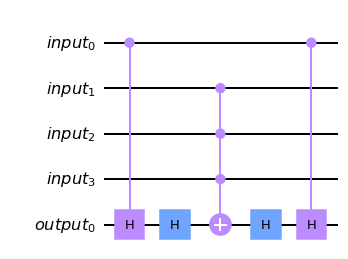

In [43]:
# Importing the qiskit module
from qiskit import *

# Defining input, output and scratch qubits
x =  4   # number of input qubits
y3 = 1  # number of output qubit 
s3 = 0 # number of scratch qubit

# Defining Quantum Circuit with the given circuits
def Circuit_3(In,Ou,Sc):
    if Sc != 0:
        # initiating required qubits
        X = QuantumRegister(In, 'input') 
        Y = QuantumRegister(Ou, 'output') 
        S = QuantumRegister(Sc, 'scratch')  
        # creating circuit with above qubits
        Circ = QuantumCircuit(X,S,Y)
    else:
        
        # initiating required qubits
        X = QuantumRegister(In, 'input') 
        Y = QuantumRegister(Ou, 'output') 
        
        # creating circuit with above qubits
        Circ = QuantumCircuit(X,Y)
    
    ##### Create you circuit below #########

#     Circ.mct([0,1,2,3],4)
    Circ = C4X(Circ, 0,1,2,3,4)
#     Circ = Circ.compose(CCH(), [0, 1, 4])

# # CCZ on q2 and q3
#     Circ = Circ.compose(CCZ(), [2, 3, 4])

# # CCH on q0 and q1
#     Circ = Circ.compose(CCH(), [0, 1, 4])
#     Circ.ccx(0,1,4)

    ########################################
    
    # Uncomment to draw quantum circuit
    display(Circ.draw('mpl'))
    
    # Transpiling the circuit into u, cnot
    Circ = transpile(Circ, basis_gates=['u3','cx'])
    # Uncomment to draw transpiled circuit
#     display(Circ.draw('mpl'))
    
    return Circ

qc_1c = Circuit_3(x,y3,s3)

### Grader

In [44]:
from qc_grader import grade_ex1c

grade_ex1c(qc_1c)

Grading your answer for ex1/partC. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 31.
Feel free to submit your answer.



# Circuit verification and Cost Metric

$\textbf{Costing metric:}$ Circuit implementation cost is computed as follows, 
$$\text{Cost} = G+D+\frac{nS}{2},$$ 
where $G$ is the number of $\text{CNOT}$ gates used (note how the single-qubit gates are "free", which takes into account their relatively small implementation cost), $D$ is the two-qubit circuit depth (defined as the maximum length of the shortest path from any starting qubit to any ending qubit in the circuit going left, up, or down along the lines in the circuit diagram and counting the number of two-qubit gates), and $S$ is the number of scratch qubits used.  The timeout for verification is set to $5$ minutes.  All implementations that time out or compute any of the popcount outputs incorrectly are assigned the score of ${+}\infty$; the implementation with the smallest value of $\text{Cost}$ wins.

### Submission for evaluation 

In [45]:
## Uncomment and run the following code to submit

from qc_grader import submit_ex1a, submit_ex1b, submit_ex1c

submit_ex1a(qc_1a)  #To submit exercise 1a

submit_ex1b(qc_1b)  #To submit exercise 1b

submit_ex1c(qc_1c)  #To submit exercise 1c

Submitting your answer for ex1/partA. Please wait...
Success 🎉! Your answer has been submitted.
Submitting your answer for ex1/partB. Please wait...
Success 🎉! Your answer has been submitted.
Submitting your answer for ex1/partC. Please wait...
Success 🎉! Your answer has been submitted.
